In [1]:
#Qiskit includes
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise.errors.readout_error import *
from qiskit.circuit import Instruction
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)
#Other python tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.lines as mlines

In [ ]:
def MatrixInversion(ymes,Rin):
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    return np.ravel(np.matmul(np.linalg.inv(np.matrix(Rin)),ymes))

def fun(x,ymes,Rin):
    mat_dot_x = np.ravel(np.matmul(Rin,x))
    return sum((ymes - mat_dot_x)**2)

def Ignis(ymes,Rin):
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    #This is copied from https://github.com/Qiskit/qiskit-ignis/blob/master/qiskit/ignis/mitigation/measurement/filters.py
    x0 = np.random.rand(len(ymes))
    x0 = x0 / sum(x0)
    nshots = sum(ymes)
    cons = ({'type': 'eq', 'fun': lambda x: nshots - sum(x)})
    bnds = tuple((0, nshots) for x in x0)
    res = minimize(fun, x0, method='SLSQP',constraints=cons, bounds=bnds, tol=1e-6, args=(ymes,Rin))
    return res.x

def IBU(ymes,t0,Rin,n):
    #This is the iterative Bayesian unfolding method.
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    #n is the number of iterations.
    
    tn = t0
    for q in range(n):
        out = []
        for j in range(len(t0)):
            mynum = 0.
            for i in range(len(ymes)):
                myden = 0.
                for k in range(len(t0)):
                    myden+=Rin[i][k]*tn[k]
                    pass
                mynum+=Rin[i][j]*tn[j]*ymes[i]/myden
                pass
            out+=[mynum]
        tn = out
        pass
    '''
    tn = t0
    for i in range(n):
        Rjitni = [np.array(Rin[:][i])*tn[i] for i in range(len(tn))]
        Pm_given_t = Rjitni / np.matmul(Rin,tn)
        tn = np.dot(Pm_given_t,ymes)
        pass
    '''
    return tn

In [67]:
def mybin(input,q,r=1):
  if (r==0):
    return bin(input).split('b')[1].zfill(q) 
  else:
    return bin(input).split('b')[1].zfill(q)[::-1]

nqubits = 5

xvals = []
xlabs = []
xlabs0 = []
for i in range(2**nqubits):
    xvals+=[i]
    xlabs+=[r'$|'+mybin(i,nqubits)+r'\rangle$']
    xlabs0+['']
    pass

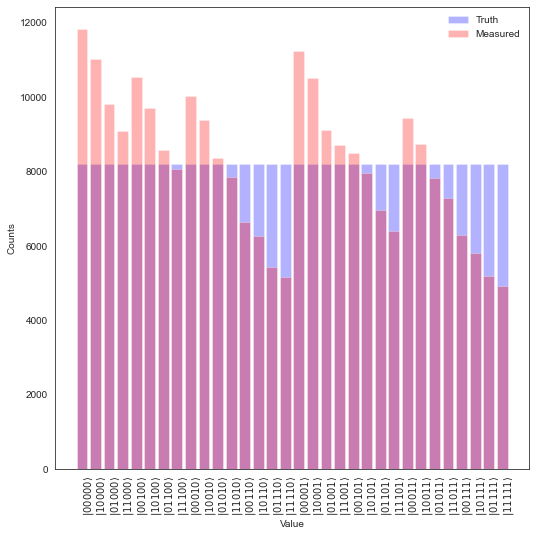

In [4]:
nqbits = 5
bin_convert = {}
for i in range(2**nqbits):
  bin_convert[bin(i).split('b')[1].zfill(nqbits)]=i
  pass

measured = np.zeros(2**nqbits)
truth = np.zeros(2**nqbits)
response = np.zeros((2**nqbits,2**nqbits))

for i in range(2**nqbits):
  myfile = open("output_gLR0_Tokyo_Unfold.dat")
  for line in myfile:
    if "Unfold_1" in line:
      myline = line.split("}")[i].split(",")
      for j in myline:
        if ":" not in j:
          continue
        outbin = 0
        counts = 0
        if "{" in j:
          outbin = int(bin_convert[j.split("{")[len(j.split("{"))-1].split(":")[0].split("'")[1]])
          counts = int(j.split("{")[len(j.split("{"))-1].split(":")[1])
        else:
          outbin = int(bin_convert[j.split(":")[0].split("'")[1]])
          counts = int(j.split(":")[1])
          pass
        truth[i] += counts
        measured[outbin] += counts
        response[outbin,i] += counts
        pass
      pass
    pass
  pass

sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
plt.bar(range(2**nqbits),truth,alpha=0.3,color='b',label='Truth')
plt.bar(range(2**nqbits),measured,alpha=0.3,color='r',label='Measured')
xvals = []
xlabs = []
for i in range(2**nqbits):
  xvals+=[i+0.5]
  xlabs+=[r'$|'+mybin(i,nqbits)+r'\rangle$']
  pass
plt.xticks(xvals,xlabs,rotation='vertical',size=10)
plt.ylabel("Counts")
plt.xlabel("Value")
plt.legend(frameon=False,loc='upper right')

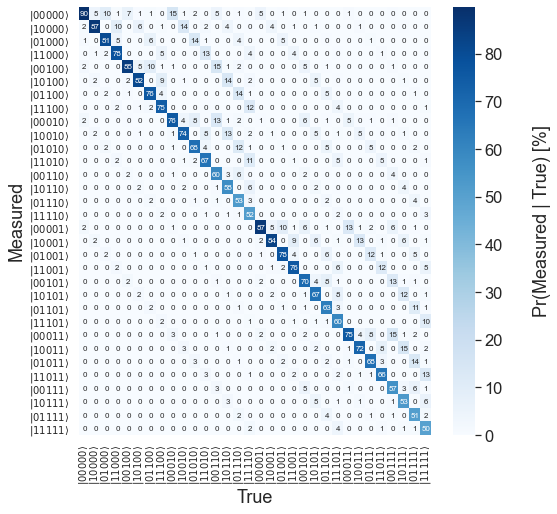

In [5]:
response_normalized = np.zeros((2**nqbits,2**nqbits))
response_normalized_reversed = np.zeros((2**nqbits,2**nqbits))
response_labels = np.zeros((2**nqbits,2**nqbits))
for i in range(2**nqbits):
  mysum = 0.
  for j in range(2**nqbits):
    mysum+=response[j,i]
    pass
  for j in range(2**nqbits):
    response_labels[j][i] = '0'
    if (mysum > 0):
      response_normalized[j,i] = 100.*response[j,i]/mysum
      response_normalized_reversed[i,j] = response_normalized[j,i]
      response_labels[j][i] = '%1.0f' % (response_normalized[j,i])
      pass
    pass
  pass

f = plt.figure(figsize=(8.5, 8.5))
sns.set(font_scale=1.5)
ax = sns.heatmap(response_normalized,annot=response_labels,annot_kws={"size": 8},cmap="Blues")
ax.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax.collections[0].colorbar
cbar.set_label('Pr(Measured | True) [%]', labelpad=30)
plt.xticks(xvals,xlabs,rotation='vertical',fontsize=10)
plt.yticks(xvals,xlabs,rotation='horizontal',fontsize=10)
plt.xlabel('True',fontsize=18)
plt.ylabel('Measured',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)

In [13]:
diagonal = [response_normalized[i][i] for i in range(2**5)]
numb0s = [xlabs[i].count("0") for i in range(2**5)]

Text(0.5, 0, 'Pr(measure correct string)')

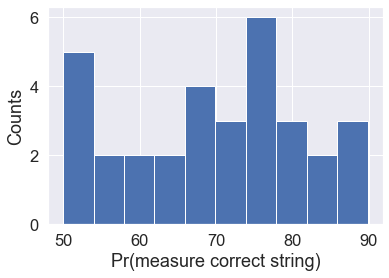

In [16]:
plt.hist(diagonal)
plt.ylabel("Counts")
plt.xlabel("Pr(measure correct string)")

Text(0, 0.5, 'Pr(measure correct string)')

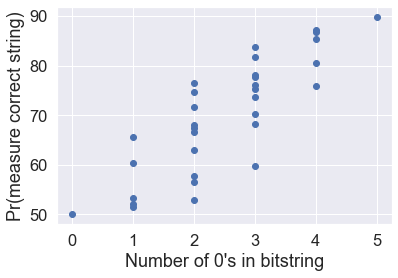

In [17]:
plt.scatter(numb0s,diagonal)
plt.xlabel("Number of 0's in bitstring")
plt.ylabel("Pr(measure correct string)")

Let's unfold some distribution that mostly ends up in the excited states and see if we can improve the fidelity by applying some x gates at the end.

In [120]:
#We can directly use the Tokyo response matrix.
nqubits_r = 5

nqubitarray_r = []
for i in range(nqubits_r):
    nqubitarray_r+=[i]
    pass 

mynoise_r = []
for i in range(2**nqubits_r):
    hold = []
    for j in range(2**nqubits_r):
        #if (i==j):
        #    hold+=[1.]
        #else:
        #    hold+=[0.]
        hold+=[response_normalized[j][i]/100.]
        pass
    mynoise_r+=[hold]
    pass
c_r = ReadoutError(mynoise_r)
noise_model_r = noise.NoiseModel()
noise_model_r.add_readout_error(c_r,nqubitarray_r)

In [126]:
#This is a special measure function that allows us to simultaneously measure multiple qubits at the same time.
measure2_r = Instruction("measure", nqubits_r, nqubits_r, [])

n = 100000

simulator_r = Aer.get_backend('qasm_simulator')

#Calibration circuit
meas_cals_mine_r = []
for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r)
    qr_r = QuantumRegister(nqubits_r, 'qr')
    cr_r = ClassicalRegister(nqubits_r, 'cr')
    circ_r = QuantumCircuit(qr_r, cr_r)
    for j in range(nqubits_r):
        if (binnumber_initial[j]=='1'):
            circ_r.x(qr_r[j])
            pass
        pass
    pass
    circ_r.name='cal_'+binnumber_initial[::-1] #Their convention is backwards of mine.
    circ_r.name=circ_r.name
    circ_r.append(measure2_r, nqubitarray_r, nqubitarray_r)
    meas_cals_mine_r+=[circ_r]
    pass

#These are our custom calibration circuits.
job_r = execute(meas_cals_mine_r, backend=simulator_r, shots=int(n/(2**nqubits_r)), noise_model=noise_model_r)
cal_results_r = job_r.result()
meas_fitter_r = CompleteMeasFitter(cal_results_r, state_labels_r)
meas_filter_r = meas_fitter_r.filter

#Let's first quickly process these
many_counts_r = []
for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r)
    counts_r = cal_results_r.get_counts(meas_cals_mine_r[i])
    many_counts_r+=[counts_r]
    pass

#Let's make our own matrix based on cal_results.
measured_cal_r = np.zeros(2**nqubits_r)
truth_cal_r = np.zeros(2**nqubits_r)
response_cal_r = np.zeros((2**nqubits_r,2**nqubits_r))
for j in range(len(many_counts_r)):
    counts = many_counts_r[j]
    for i in range(2**nqubits_r):
        binnumber_initial = mybin(i,nqubits_r,0)
        if (binnumber_initial in counts):
            measured_cal_r[i]+=counts[binnumber_initial]
            truth_cal_r[j]+=counts[binnumber_initial]
            response_cal_r[i,j]+=counts[binnumber_initial]
            pass
        pass
    pass
response_normalized_cal_r = np.zeros((2**nqubits_r,2**nqubits_r))
for i in range(len(truth_cal_r)):
    for j in range(len(truth_cal_r)):
        response_normalized_cal_r[i,j]=response_cal_r[i,j]/truth_cal_r[j]
        pass
    pass

In [127]:
#Implementation from https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/w_state/W%20State%201%20-%20Multi-Qubit%20Systems.ipynb

# Here, two useful routine
# Define a F_gate
def F_gate(circ,q,i,j,n,k) :
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta,q[j])       
    circ.cz(q[i],q[j])
    circ.ry(theta,q[j])
    circ.barrier(q[i])
# Define the cxrv gate which uses reverse CNOT instead of CNOT
def  cxrv(circ,q,i,j) :
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j],q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i],q[j])
    
# 5-qubit W state
nq = 5
q = QuantumRegister(nq) 
c = ClassicalRegister(nq)
W_states = QuantumCircuit(q,c) 

W_states.x(q[4]) #start is |10000>
F_gate(W_states,q,4,3,5,1) # Applying F12
F_gate(W_states,q,3,2,5,2) # Applying F23
F_gate(W_states,q,2,1,5,3) # Applying F34
F_gate(W_states,q,1,0,5,4) # Applying F45
W_states.cx(q[3],q[4]) # cNOT 21
cxrv(W_states,q,2,3)   # cNOT 32
W_states.cx(q[1],q[2]) # cNOT 43
W_states.cx(q[0],q[1]) # cNOT 54 
for i in range(5) : #Inverted W state
    W_states.x([q[i]])
#for i in range(5) :
#    W_states.measure(q[i] , c[i]) 
W_states.append(measure2_r, nqubitarray_r, nqubitarray_r)
    
shots = 1024
result = execute(W_states, simulator_r, shots=shots).result()
result.get_counts()

{'01111': 204, '10111': 177, '11011': 189, '11101': 215, '11110': 239}

In [142]:
W_states_nominal = QuantumCircuit(q,c) 

W_states_nominal.x(q[4]) #start is |10000>
F_gate(W_states_nominal,q,4,3,5,1) # Applying F12
F_gate(W_states_nominal,q,3,2,5,2) # Applying F23
F_gate(W_states_nominal,q,2,1,5,3) # Applying F34
F_gate(W_states_nominal,q,1,0,5,4) # Applying F45
W_states_nominal.cx(q[3],q[4]) # cNOT 21
cxrv(W_states_nominal,q,2,3)   # cNOT 32
W_states_nominal.cx(q[1],q[2]) # cNOT 43
W_states_nominal.cx(q[0],q[1]) # cNOT 54 
W_states_nominal.append(measure2_r, nqubitarray_r, nqubitarray_r)
    
result = execute(W_states_nominal, simulator_r, shots=shots).result()
result.get_counts()

{'00001': 218, '00100': 199, '00010': 185, '10000': 225, '01000': 197}

In [128]:
#Now, for the actual measurement

counts_true = execute(W_states, simulator_r, shots=n).result().get_counts()
counts_test = execute(W_states, simulator_r, shots=n, noise_model=noise_model_r).result().get_counts()

for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r,0)
    truth_test_r[i] = 0
    measured_test_r[i] = 0
    if (binnumber_initial in counts_true):
        truth_test_r[i]+=counts_true[binnumber_initial]
    if (binnumber_initial in counts_test):
        measured_test_r[i]+=counts_test[binnumber_initial]

In [135]:
#Now, for the unfolding.
unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100)

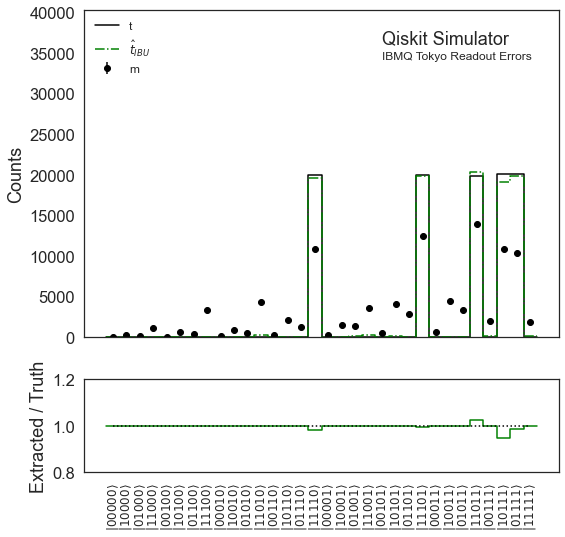

In [136]:
def myre(x):
    return np.concatenate([[x[0]],x])

bincenters_r = np.array(xvals)+0.5
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[3.5, 1])
ax1 = plt.subplot(gs[0])
ax1.set_xticklabels( () )

mybincenters = np.linspace(-0.5,31.5,33)
plt.step(mybincenters,myre(truth_test_r),color='black',label=r"t")
plt.errorbar(0.5*(mybincenters[1:]+mybincenters[:-1]),measured_test_r,yerr=np.sqrt(measured_test_r),label='m',marker='o',linestyle='none',color='black')
plt.step(mybincenters,myre(unfolded_IBU_r),color='green',linestyle='-.',label=r"$\hat{t}_{IBU}$")

_=plt.xticks(xvals,xlabs0,rotation='vertical',fontsize=10)
plt.ylabel('Counts')
plt.ylim([0,2.*max(truth_test_r)])
plt.legend(loc='upper left',fontsize=12,frameon=False)
_=plt.text(20., max(truth_test_r)*1.8, "Qiskit Simulator", fontsize=18)
_=plt.text(20., max(truth_test_r)*1.7, "IBMQ Tokyo Readout Errors", fontsize=12)

ax2 = plt.subplot(gs[1])
ratio_ignis2_r = np.zeros(2**nqubits_r)
ratio_ignis_r = np.zeros(2**nqubits_r)
ratio_matrix_r = np.zeros(2**nqubits_r)
ratio_unfold_r = np.zeros(2**nqubits_r)
for i in range(len(ratio_unfold_r)):
    ratio_unfold_r[i]=1.
    if (truth_test_r[i] > 0):
        ratio_unfold_r[i] = unfolded_IBU_r[i]/truth_test_r[i]
        pass
    pass

plt.ylim([0.8,1.2])
plt.step(mybincenters,myre(ratio_unfold_r),color='green')
plt.ylabel('Extracted / Truth')
xx2 = [1.,1.]
plt.plot([xvals[0],xvals[len(xvals)-1]],xx2,color='black',linestyle=':')
_=plt.xticks(xvals,xlabs,rotation='vertical',fontsize=12)
#plt.savefig("plots/fig4_rr.pdf",bbox_inches='tight')

In [ ]:
#Okay, maybe we should show what happens if you have the wrong matrix?  Or maybe the statistical uncertainty?

In [161]:
mycheck = []
mycheckb = []

for i in range(10):

    print("on i=",i)
    
    counts_true = execute(W_states, simulator_r, shots=n).result().get_counts()
    counts_test = execute(W_states, simulator_r, shots=n, noise_model=noise_model_r).result().get_counts()

    for i in range(2**nqubits_r):
        binnumber_initial = mybin(i,nqubits_r,0)
        truth_test_r[i] = 0
        measured_test_r[i] = 0
        if (binnumber_initial in counts_true):
            truth_test_r[i]+=counts_true[binnumber_initial]
        if (binnumber_initial in counts_test):
            measured_test_r[i]+=counts_test[binnumber_initial]
    unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100)
    mycheck += [unfolded_IBU_r[-2]]
    mycheck += [unfolded_IBU_r[-3]]    
    mycheck += [unfolded_IBU_r[-5]]    
    mycheck += [unfolded_IBU_r[-9]] 
    mycheck += [unfolded_IBU_r[-17]]     
    
    counts_true = execute(W_states_nominal, simulator_r, shots=n).result().get_counts()
    counts_test = execute(W_states_nominal, simulator_r, shots=n, noise_model=noise_model_r).result().get_counts()

    for i in range(2**nqubits_r):
        binnumber_initial = mybin(i,nqubits_r,0)
        truth_test_r[i] = 0
        measured_test_r[i] = 0
        if (binnumber_initial in counts_true):
            truth_test_r[i]+=counts_true[binnumber_initial]
        if (binnumber_initial in counts_test):
            measured_test_r[i]+=counts_test[binnumber_initial]
    unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100)
    mycheckb += [unfolded_IBU_r[1]]
    mycheckb += [unfolded_IBU_r[2]]    
    mycheckb += [unfolded_IBU_r[4]]    
    mycheckb += [unfolded_IBU_r[8]] 
    mycheckb += [unfolded_IBU_r[16]]    

on i= 0
on i= 1
on i= 2
on i= 3
on i= 4
on i= 5
on i= 6
on i= 7
on i= 8
on i= 9


In [162]:
print(np.std(mycheck),np.std(mycheckb))

352.2050366351951 250.46211844677313


In [165]:
250/350.

0.7142857142857143

Now, we need a method for deciding which bits to flip.  One possibility is to check all 2^n states and minimize the expected number of 1's in the output bit string.  A simpler idea is to simply compute the average output for a given qubit and flip it if it is above 0.5.

In [171]:
#First, let's consider all possible combinations of x gates.
print("average number of ones in nominal circuit: ",sum(np.array(unfolded_IBU_r)*np.array(numb0s))/sum(unfolded_IBU_r))

average number of ones in nominal circuit:  3.9968620521328004


In [198]:
mymin = 999.
xlabs_hold = xlabs
swaps = []
for q0 in [0,1]:
    for q1 in [0,1]:
        for q2 in [0,1]:
            for q3 in [0,1]:
                for q4 in [0,1]:
                    for i in range(2,7):
                        for j in range(len(xlabs_hold)):
                            xlabs_hold[j] = list(xlabs_hold[j])
                            if q0==1:
                                xlabs_hold[j][2]=str(1-int(xlabs_hold[j][2]))
                            if q1==1:
                                xlabs_hold[j][3]=str(1-int(xlabs_hold[j][3]))
                            if q2==1:
                                xlabs_hold[j][4]=str(1-int(xlabs_hold[j][4]))
                            if q3==1:
                                xlabs_hold[j][5]=str(1-int(xlabs_hold[j][5]))
                            if q4==1:
                                xlabs_hold[j][6]=str(1-int(xlabs_hold[j][6]))
                            xlabs_hold[j] = "".join(xlabs_hold[j])
                            pass
                        numb0s_hold = [xlabs_hold[i].count("0") for i in range(2**5)]
                        val = sum(np.array(unfolded_IBU_r)*np.array(numb0s_hold))/sum(unfolded_IBU_r)
                        #print(sum(np.array(unfolded_IBU_r)*np.array(numb0s_hold))/sum(unfolded_IBU_r),[q0,q1,q2,q3,q4])
                        if (val < mymin):
                            mymin = val
                            swaps = [q0,q1,q2,q3,q4]
            
print(mymin,swaps)

1.0031379478672013 [1, 1, 1, 1, 0]
